<a href="https://colab.research.google.com/github/SNCA-24/Grid-Navigation-using-MDP-framewrok-in-RL/blob/main/Navigation_Agent_using_MDP_in_Re_inforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starter Code

In [ ]:
#graph creation
def create_graph(rows, cols, obstacles):
    graph = {}

    for r in range(1, rows + 1):
        for c in range(1, cols + 1):
            if (r, c) not in obstacles:
                neighbors = []
                for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:  # Right, Left, Up, Down
                    nr, nc = r + dr, c + dc
                    if 1 <= nr <= rows and 1 <= nc <= cols and (nr, nc) not in obstacles:
                        neighbors.append((nr, nc))
                graph[(r, c)] = neighbors

    return graph

# Define grid parameters
rows, cols = 5, 5
obstacles = [(3, 2), (3, 4), (5, 5)]
destination = (3, 5)
hazards = [(1, c) for c in range(1, 6)]  # Bottom row

# Create the graph
grid_graph = create_graph(rows, cols, obstacles)

# Print the graph to verify
for position, neighbors in grid_graph.items():
    print(f"{position}: {neighbors}")

(1, 1): [(1, 2), (2, 1)]
(1, 2): [(1, 3), (1, 1), (2, 2)]
(1, 3): [(1, 4), (1, 2), (2, 3)]
(1, 4): [(1, 5), (1, 3), (2, 4)]
(1, 5): [(1, 4), (2, 5)]
(2, 1): [(2, 2), (3, 1), (1, 1)]
(2, 2): [(2, 3), (2, 1), (1, 2)]
(2, 3): [(2, 4), (2, 2), (3, 3), (1, 3)]
(2, 4): [(2, 5), (2, 3), (1, 4)]
(2, 5): [(2, 4), (3, 5), (1, 5)]
(3, 1): [(4, 1), (2, 1)]
(3, 3): [(4, 3), (2, 3)]
(3, 5): [(4, 5), (2, 5)]
(4, 1): [(4, 2), (5, 1), (3, 1)]
(4, 2): [(4, 3), (4, 1), (5, 2)]
(4, 3): [(4, 4), (4, 2), (5, 3), (3, 3)]
(4, 4): [(4, 5), (4, 3), (5, 4)]
(4, 5): [(4, 4), (3, 5)]
(5, 1): [(5, 2), (4, 1)]
(5, 2): [(5, 3), (5, 1), (4, 2)]
(5, 3): [(5, 4), (5, 2), (4, 3)]
(5, 4): [(5, 3), (4, 4)]


##R1

In [ ]:
# R1 Code
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Environment setup
rows, cols = 5, 5
obstacles = [(3, 2), (3, 4), (5, 5)]
destination = (3, 5)
hazards = [(1, c) for c in range(1, 6)]

# MDP parameters
gamma = 0.99
epsilon = 0.001
max_iterations = 100
noise = 0.1  # Updated noise factor

def create_graph():
#Create a graph representation of the grid with valid transitions.
    graph = defaultdict(list)
    for r in range(1, rows + 1):
        for c in range(1, cols + 1):
            if (r, c) not in obstacles:
                for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:  # Right, Left, Up, Down
                    nr, nc = r + dr, c + dc
                    if 1 <= nr <= rows and 1 <= nc <= cols and (nr, nc) not in obstacles:
                        graph[(r, c)].append((nr, nc))
    return graph

def get_reward(state):
# Get the reward for a given state.
    if state == destination:
        return 10
    elif state in hazards:
        return -10
    else:
        return 0  # Default reward

def get_transition_probabilities(state, action, graph):
# Get transition probabilities considering noise.

    probs = defaultdict(float)
    intended_state = action
    valid_actions = graph[state]

    if intended_state in valid_actions:
        probs[intended_state] = 1 - noise
        other_actions = [a for a in valid_actions if a != intended_state]
        for a in other_actions:
            probs[a] = noise / len(other_actions)
    else:
        for a in valid_actions:
            probs[a] = 1.0 / len(valid_actions)

    return probs

def value_iteration(graph, r):
# Perform value iteration for a given live-in reward r.
    V = {state: 0 for state in graph}
    for _ in range(max_iterations):
        delta = 0
        for state in graph:
            if state == destination or state in hazards:
                continue
            v = V[state]
            values = []
            for action in graph[state]:
                value = 0
                for next_state, prob in get_transition_probabilities(state, action, graph).items():
                    reward = r if get_reward(next_state) == 0 else get_reward(next_state)
                    value += prob * (reward + gamma * V[next_state])
                values.append(value)
            V[state] = max(values)
            delta = max(delta, abs(v - V[state]))
        if delta < epsilon:
            break
    return V

def extract_policy(V, graph, r, destination, hazards, obstacles):
    policy = {}
    for state in graph:
        if state == destination:
            policy[state] = 'D'
        elif state in hazards:
            policy[state] = 'H'
        elif state in obstacles:
            policy[state] = 'X'
        else:
            values = []
            for action in graph[state]:
                value = 0
                for next_state, prob in get_transition_probabilities(state, action, graph).items():
                    reward = r if get_reward(next_state) == 0 else get_reward(next_state)
                    value += prob * (reward + gamma * V[next_state])
                values.append(value)
            best_action = graph[state][np.argmax(values)]
            dr, dc = best_action[0] - state[0], best_action[1] - state[1]
            if (dr, dc) == (0, 1):
                policy[state] = '→'
            elif (dr, dc) == (0, -1):
                policy[state] = '←'
            elif (dr, dc) == (1, 0):
                policy[state] = '↑'
            elif (dr, dc) == (-1, 0):
                policy[state] = '↓'
    return policy

graph = create_graph()

best_r = None #The optimal live-in reward value
best_policy = None #The optimal policy
best_value_sum = float('-inf') # The highest sum of state values
best_V = None # optimal value function

for r in np.arange(-0.3, -0.05, 0.05):
    V = value_iteration(graph, r)
    policy = extract_policy(V, graph, r, destination, hazards, obstacles)
    value_sum = sum(V.values())
    if value_sum > best_value_sum:
        best_value_sum = value_sum
        best_r = r
        best_policy = policy
        best_V = V

print(f"a) Best live-in reward (r): {best_r}")
print("\nb) Best policy P1 (arrows):")
for i in range(rows, 0, -1):
    row = [best_policy.get((i, j), ' ') for j in range(1, cols + 1)]
    print(' '.join(row))
print("\nNumeric values after Value Iteration:")
for i in range(rows, 0, -1):
    row = [f"{best_V.get((i, j), 0):6.2f}" for j in range(1, cols + 1)]
    print(' '.join(row))


a) Best live-in reward (r): -0.10000000000000003

b) Best policy P1 (arrows):
→ → → ↓  
→ → → → ↓
↑   ↑   D
↑ → ↑ → ↑
H H H H H

Numeric values after Value Iteration:
  8.83   9.03   9.24   9.46   0.00
  8.98   9.22   9.46   9.70   9.95
  8.64   0.00   9.14   0.00   0.00
  7.45   7.08   8.20   7.72   8.88
  0.00   0.00   0.00   0.00   0.00


In [ ]:
# if we wanted to include the reward which is at position 3,3 the we can update the get reward code in this way
def get_reward(state):
    if state == destination:
        return 10
    elif state == (3, 3):
        return 1
    elif state in hazards:
        return -10
    else:
        return 0

##R2


Policy P1:
→ → → ↓  X
→ → → → ↓
↑  X ↑  X D
↑ → → → ↑
H H H H H

Policy P2:
→ → → → ↓
→ ↑ ↑ X  ↓
↑ X  ↑ X  D
↑ → → → ↑
H H H H H

Differences between P1 and P2:
Position (4,2): P1 = →, P2 = ↑
Position (4,3): P1 = →, P2 = ↑
Position (4,4): P1 = →, P2 =  
Position (5,4): P1 = ↓, P2 = →
Position (5,5): P1 =  , P2 = ↓




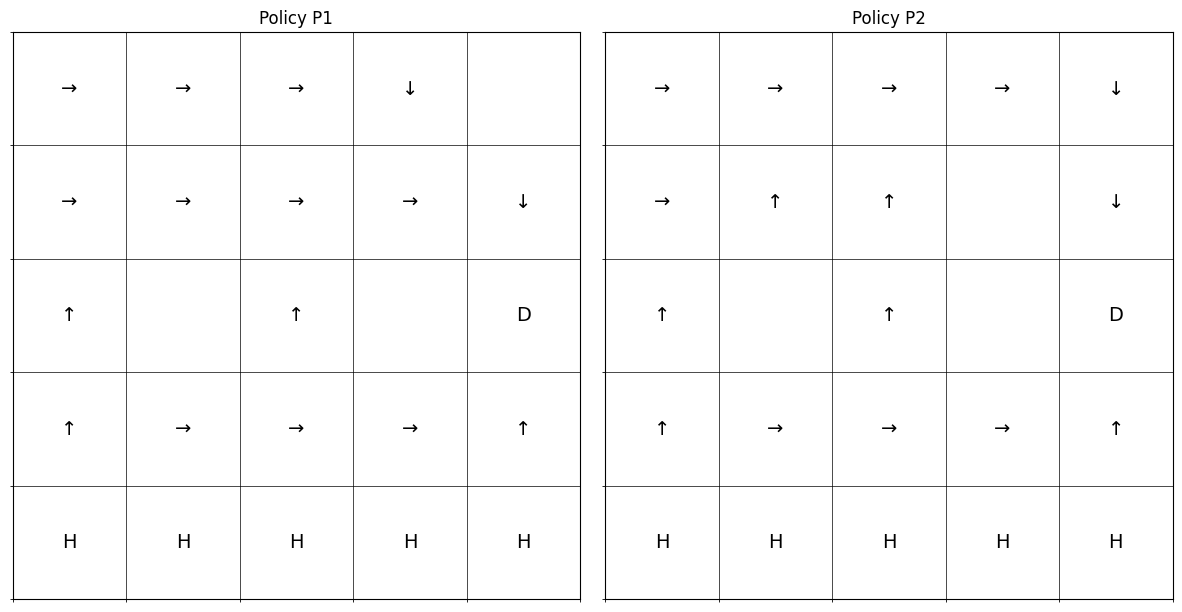

In [ ]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
# Environment setup
rows, cols = 5, 5
destination = (3, 5)
hazards = [(1, c) for c in range(1, 6)]

# MDP parameters
gamma = 0.99
epsilon = 0.001
max_iterations = 100

def create_graph(obstacles):
    graph = defaultdict(list)
    for r in range(1, rows + 1):
        for c in range(1, cols + 1):
            if (r, c) not in obstacles:
                for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:  # Right, Left, Up, Down
                    nr, nc = r + dr, c + dc
                    if 1 <= nr <= rows and 1 <= nc <= cols and (nr, nc) not in obstacles:
                        graph[(r, c)].append((nr, nc))
    return graph

def get_reward(state):
    if state == destination:
        return 10
    elif state in hazards:
        return -10
    else:
        return 0  # Will be replaced by live-in reward r

def get_transition_probabilities(state, action, graph):
# Get transition probabilities considering noise.

    probs = defaultdict(float)
    intended_state = action
    valid_actions = graph[state]

    if intended_state in valid_actions:
        probs[intended_state] = 1 - noise
        other_actions = [a for a in valid_actions if a != intended_state]
        for a in other_actions:
            probs[a] = noise / len(other_actions)
    else:
        for a in valid_actions:
            probs[a] = 1.0 / len(valid_actions)

    return probs
def value_iteration(graph, r):
# Perform value iteration for a given live-in reward r.


    V = {state: 0 for state in graph}
    for _ in range(max_iterations):
        delta = 0
        for state in graph:
            if state == destination or state in hazards:
                continue
            v = V[state]
            values = []
            for action in graph[state]:
                value = 0
                for next_state, prob in get_transition_probabilities(state, action, graph).items():
                    reward = r if get_reward(next_state) == 0 else get_reward(next_state)
                    value += prob * (reward + gamma * V[next_state])
            values.append(value)
            V[state] = max(values)
            delta = max(delta, abs(v - V[state]))
        if delta < epsilon:
            break
    return V


#  Extract the policy from the value function.

def extract_policy(V, graph, r, destination, hazards, obstacles):
    policy = {}
    for state in graph:
        if state == destination:
            policy[state] = 'D'
        elif state in hazards:
            policy[state] = 'H'
        elif state in obstacles:
            policy[state] = 'X'
        else:
            values = []
            for action in graph[state]:
                value = 0
                for next_state, prob in get_transition_probabilities(state, action, graph).items():
                    reward = r if get_reward(next_state) == 0 else get_reward(next_state)
                    value += prob * (reward + gamma * V[next_state])
                values.append(value)
            best_action = graph[state][np.argmax(values)]
            dr, dc = best_action[0] - state[0], best_action[1] - state[1]
            if (dr, dc) == (0, 1):
                policy[state] = '→'
            elif (dr, dc) == (0, -1):
                policy[state] = '←'
            elif (dr, dc) == (1, 0):
                policy[state] = '↑'
            elif (dr, dc) == (-1, 0):
                policy[state] = '↓'
    return policy

# Create P1
obstacles_P1 = [(3, 2), (3, 4), (5, 5)]
graph_P1 = create_graph(obstacles_P1)

# Find the best live-in reward
best_r = None
best_value_sum = float('-inf')

for r in np.arange(-0.3, -0.05, 0.05):
    V = value_iteration(graph_P1, r)
    value_sum = sum(V.values())
    if value_sum > best_value_sum:
        best_value_sum = value_sum
        best_r_P1 = r

V_P1 = value_iteration(graph_P1, best_r_P1)
P1 = extract_policy(V_P1, graph_P1, best_r_P1,  destination, hazards, obstacles_P1)

# Create P2
obstacles_P2 = [(3, 2), (3, 4), (4, 4)]  # Changed from (5, 5) to (4, 4)
graph_P2 = create_graph(obstacles_P2)

for r in np.arange(-0.3, -0.05, 0.05):
    V = value_iteration(graph_P2, r)
    value_sum = sum(V.values())
    if value_sum > best_value_sum:
        best_value_sum = value_sum
        best_r_P2 = r

V_P2 = value_iteration(graph_P2, best_r_P2)
P2 = extract_policy(V_P2, graph_P2, best_r_P2,  destination, hazards, obstacles_P2)

def visualize_policies(P1, P2, rows, cols):
# Visualize the original and modified policies side by side.

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, policy, title, obstacles in zip(axes, [P1, P2], ["Policy P1", "Policy P2"],[obstacles_P1,obstacles_P2]):
        # Create a grid to display the policies
        grid = np.full((rows, cols), ' ')
        for r in range(1, rows + 1):
            for c in range(1, cols + 1):
                grid[r - 1, c - 1] = policy.get((r, c), ' ')

        # Setting up the visualization grid
        ax.imshow(np.zeros((rows, cols)), cmap="Greys", alpha=0.3)
        for r in range(rows):
            for c in range(cols):
                # Place the text in the center of each cell
                ax.text(c, rows - r - 1, grid[r, c],
                        fontsize=14, ha='center', va='center')

        # Adding gridlines and adjust layout
        ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)
    plt.tight_layout()
    plt.show()
print("\nPolicy P1:")
for i in range(rows, 0, -1):
    row = [P1.get((i, j), ' X') for j in range(1, cols + 1)]
    print(' '.join(row))

print("\nPolicy P2:")
for i in range(rows, 0, -1):
    row = [P2.get((i, j), 'X ') for j in range(1, cols + 1)]
    print(' '.join(row))

print("\nDifferences between P1 and P2:")
for i in range(1, rows + 1):
    for j in range(1, cols + 1):
        if P1.get((i, j), ' ') != P2.get((i, j), ' '):
            print(f"Position ({i},{j}): P1 = {P1.get((i, j), ' ')}, P2 = {P2.get((i, j), ' ')}")
print('\n')
visualize_policies(P1, P2, rows, cols)

##R3

Pseudo-Code for Modification for dynamic environments

In [ ]:
#R3

#To adapt MDP for dynamic environment we need to update the following functions in the way those can handle multiple mobile agents
#for multi agent environment
#state: position of robot, action: moving direction, occupancy_probs: probability occupied by the robot

def get_transition_probs(state, action, graph, occupancy_probs):
    probs = defaultdict(float) #store transition probabilities
    intended_state = action
    valid_actions = graph[state]
#robot choosen state
    if intended_state in valid_actions:
        prob_free = 1 - occupancy_probs[intended_state] #probability for the intended state is free
        probs[intended_state] = 0.9 * prob_free
        probs[state] += 0.9 * (1 - prob_free)
#all possible actions from their position (both valid and invalid) and adjust probabilities
        other_actions = [a for a in valid_actions if a != intended_state]
        for a in other_actions:
            prob_free_other = 1 - occupancy_probs[a]
            probs[a] = 0.1 * prob_free_other / len(other_actions)
            probs[state] += 0.1 * (1 - prob_free_other) / len(other_actions)
    else:# if intended actions are invalid the probability is given to valid actions
        for a in valid_actions:
            prob_free = 1 - occupancy_probs[a]
            probs[a] = prob_free / len(valid_actions)
            probs[state] += (1 - prob_free) / len(valid_actions)

    return probs
#value iteration function
def dynamic_value_iteration(graph, r, occupancy_probs):
    V = {state: 0 for state in graph} #initializing the value function
    for _ in range(max_iterations):
        delta = 0
        for state in graph:
            if state == destination or state in hazards:
                continue
            v = V[state]
            values = []
            for action in graph[state]:
                value = 0
                for next_state in graph:
                    # P(s'|s,a) this include probability of other robots positions
                    prob =get_transition_probs(state, action, next_state)
                    # R(s,a,s') may include collision penalties
                    r = r(state, action, next_state)
                    value += prob * (r + gamma * V[next_state])
                values.append(value)
            V[state] = max(values)
            delta = max(delta, abs(v - V[state]))
        if delta < epsilon:
            break
    return V


for R3
we can deal with multi mobile agents environment:

*   by extending the state space to have positions for all robots.
*   by updating the transition function in this way we can handle obstacles
*  by Including the probability of cell occupancy of other robots into decision-making.
*   Periodically changing the policy by considering the new environment info.
*   Balancing between efficient path planning and collision avoidance.




